In [373]:
import functools
import os
import pandas as pd
import e3x
import flax.linen as nn
import jax
import numpy as np
import optax
# Disable future warnings.
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.set_cmap('bwr')

import jax.numpy as jnp
from jax import jit, grad
from jax import vmap
batch_size = 1
NATOMS = 60

<Figure size 640x480 with 0 Axes>

In [374]:
def evaluate_dc(batch, dipo, mono, batch_size, plot=False, rcut=10000):
    esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                             batch['vdw_surface'], batch['mono'], 
                             batch_size)

    mono_pred =  esp_loss_pots(batch['positions'], batch['mono'], batch['esp'],
                        batch['vdw_surface'], batch['mono'], batch_size)

    non_zero = np.nonzero(batch["mono"])

    if plot:
    
        plt.scatter(batch["mono"][non_zero], 
                    mono.sum(axis=-1).squeeze()[non_zero])
        loss = esp_loss_eval(batch["mono"][non_zero], mono.sum(axis=-1).squeeze()[non_zero], None)
        plt.title(loss)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.show()
        
        for id in range(batch_size):
            plt.scatter(esp_dc_pred[id][:batch['ngrid'][id]],
                        batch['esp'][id][:batch['ngrid'][id]], alpha=0.1)
     
        ax = plt.gca()
        plt.xlim(-0.1, 0.1)
        plt.ylim(-0.1, 0.1)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        ax.set_aspect("equal")
        plt.show()

    esp_errors = []
    
    for mbID in range(batch_size):
        xyzs = batch['positions'].reshape(batch_size,60, 3)
        vdws = batch['vdw_surface'][mbID][:batch['ngrid'][mbID]]
        diff = xyzs[mbID][:, None, :] - vdws[None, :, :]
        r = np.linalg.norm(diff, axis=-1) 
        min_d = np.min(r, axis=-2)
        wheremind = np.where( min_d < rcut, min_d, 0)
        idx_cut = np.nonzero(wheremind)[0]
        loss1 = esp_loss_eval(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        loss2 = esp_loss_eval(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        esp_errors.append([loss1, loss2])

        if plot:
            
            fig = plt.figure(figsize=(12,6))
            
            ax1 = fig.add_subplot(151, projection='3d')
            s = ax1.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax1.set_title(f"GT {mbID}")
            
    
            ax2 = fig.add_subplot(152, projection='3d')
            s = ax2.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax2.set_title(loss1)
            
            ax4 = fig.add_subplot(153, projection='3d')
            s = ax4.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
            ax3 = fig.add_subplot(154, projection='3d')
            s = ax3.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax3.set_title(loss2)
    
            ax5 = fig.add_subplot(155, projection='3d')
            s = ax5.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
    
            for _ in [ax1,ax2,ax3]:
                _.set_xlim(-10,10)
                _.set_ylim(-10,10)
                _.set_zlim(-10,10)
            plt.show()
        
    return esp_errors


In [375]:
from esp_net import prepare_datasets,prepare_batches

def nan_safe_coulomb_potential(q, r):
    potential = jnp.where(jnp.isnan(r) | (r == 0.0), 0.0, q / (r * 1.88973))
    return potential


def calc_esp(charge_positions, charge_values, grid_positions, mono):
    chg_mask = jnp.where(mono != 0, 1.0, 0.0)
    # Expand the grid positions and charge positions to compute all pairwise differences
    diff = grid_positions[:, None, :] - charge_positions[None, :, :]
    # Compute the Euclidean distance between each grid point and each charge
    r = jnp.linalg.norm(diff, axis=-1)
    sum_chg = jnp.sum(chg_mask * charge_values)
    # jax.debug.print("x = {x}", x=sum_chg)
    avg_chg = jnp.sum(chg_mask * charge_values) / jnp.sum(chg_mask)
    new_charge_values = charge_values - avg_chg
    # sum_chg_new = jnp.sum(chg_mask * new_charge_values)
    # jax.debug.print("x2 = {x}", x=sum_chg_new)
    C = nan_safe_coulomb_potential((chg_mask * new_charge_values)[None, :], r)
    V = jnp.sum(C, axis=-1)
    return V

def esp_loss_eval(pred, target, ngrid):
    target = target.flatten()
    esp_non_zero = np.nonzero(target)
    l2_loss = optax.l2_loss(pred[esp_non_zero], target[esp_non_zero])
    esp_loss = np.mean(l2_loss)
    esp_loss = esp_loss * 1  
    return esp_loss
    
batched_electrostatic_potential = vmap(calc_esp, in_axes=(0, 0, 0, 0), out_axes=0)


def clip_colors(c):
    return np.clip(c, -0.015, 0.015)


@functools.partial(jax.jit, static_argnames=('batch_size', 'esp_w'))
def esp_mono_loss(dipo_prediction, mono_prediction, esp_target,
                  vdw_surface, mono, batch_size, esp_w):
    """
    """
    nonzero = jnp.nonzero(mono, size=batch_size * 60)
    l2_loss_mono = optax.l2_loss(mono_prediction.sum(axis=-1), mono)
    mono_loss = jnp.mean(l2_loss_mono[nonzero])

    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono).flatten()
    esp_target = esp_target.flatten()
    esp_non_zero = jnp.nonzero(esp_target, size=batch_size * 3143)

    l2_loss = optax.l2_loss(batched_pred, esp_target)
    esp_loss = jnp.mean(l2_loss[esp_non_zero])
    esp_loss = esp_loss * esp_w
    return esp_loss + mono_loss


def esp_mono_loss_pots(dipo_prediction, mono_prediction, esp_target,
                       vdw_surface, mono, batch_size):
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def esp_loss_pots(dipo_prediction, mono_prediction,
                  esp_target, vdw_surface, mono, batch_size):
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def mean_absolute_error(prediction, target, batch_size):
    nonzero = jnp.nonzero(target, size=batch_size * 60)
    return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

In [376]:
NATOMS = 60
class MessagePassingModel(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 17
    n_dcm: int = 4

    def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments,
             batch_size):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
        )

        x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1,
                         features=self.features)(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(max_degree=max_degree,
                                       include_pseudotensors=False
                                       )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=n_dcm,
            max_degree=1,
            include_pseudotensors=False,
        )(x)

        atomic_mono = e3x.nn.change_max_degree_or_type(x,
                                                       max_degree=0,
                                                       include_pseudotensors=False)
        element_bias = self.param('element_bias',
                                  lambda rng, shape: jnp.zeros(shape),
                                  (self.max_atomic_number + 1))
        atomic_mono = nn.Dense(n_dcm, use_bias=False,
                               )(atomic_mono)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono += element_bias[atomic_numbers][:, None]
        
        atomic_dipo = x[:, 1, 1:4, :]
        atomic_dipo = e3x.nn.silu(atomic_dipo)
        atomic_dipo = jnp.clip(atomic_dipo, a_min=-0.3, a_max=0.3)
        atomic_dipo += positions[:, :, None]

        return atomic_mono, atomic_dipo

    @nn.compact
    def __call__(self, atomic_numbers, positions, dst_idx, src_idx,
                 batch_segments=None, batch_size=None):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments,
                         batch_size)

In [377]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def process_df(errors):
    h2kcal = 627.509
    df = pd.DataFrame(flatten(errors))
    df["model"] = df[0].apply(lambda x: np.sqrt(x)*h2kcal)
    df["mono"] = df[1].apply(lambda x: np.sqrt(x)*h2kcal)
    df["dif"] =  df["model"] - df["mono"]
    return df

# Data

In [378]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(
    0
), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    10000 - 16,
    16,
    filename="data/qm9-esp10000.npz")

R (10000, 60, 3)
Z (10000, 60)
N (10000,)
mono (10000, 60, 1)
esp (10000, 3143)
n_grid (10000,)
vdw_surface (10000, 3143, 3)
10000
...
...
atomic_numbers (9984, 60)
ngrid (9984,)
positions (9984, 60, 3)
mono (9984, 60, 1)
esp (9984, 3143)
vdw_surface (9984, 3143, 3)
...
atomic_numbers (16, 60)
positions (16, 60, 3)
mono (16, 60, 1)
ngrid (16,)
esp (16, 3143)
vdw_surface (16, 3143, 3)


In [379]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

16


In [380]:
train_batches = prepare_batches(data_key, train_data, batch_size)
print(len(train_batches))

9984


In [381]:
NTRAINEVAL = 10

In [382]:
from pathlib import Path
import pandas as pd

def get_lowest_loss(path, df=False):
    paths = []
    losses = []
    for _ in Path(path).glob("*.pkl"):
        loss = float((_.stem).split("-")[1])
        paths.append(_)
        losses.append(loss)
    if df:
        return pd.DataFrame([paths, losses]).T.sort_values(1)
    else:
        return pd.DataFrame([paths, losses]).T.sort_values(1).iloc[0][0]

#  DCM1

In [383]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 1
# Training hyperparameters.
learning_rate = 0.001
# batch_size = 1
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
DCM1 = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

# params = pd.read_pickle("checkpoints/dcm1-10000.0/1-0.053797438740730286-esp_params.pkl")

params = pd.read_pickle(get_lowest_loss("checkpoints/dcm1-10000.0/"))

# params = pd.read_pickle("checkpoints/dcm1-10.0/8-0.00036029628245159984-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-100.0/27-0.0014055122155696154-esp_params.pkl")

DCM1

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 1
)

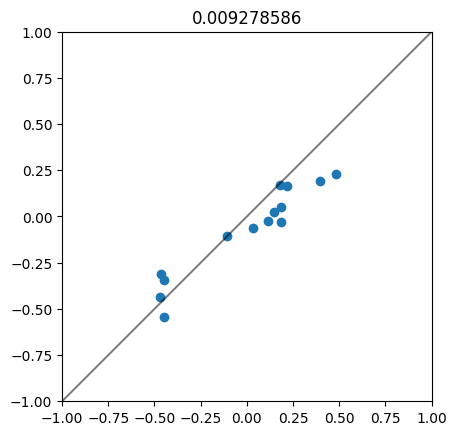

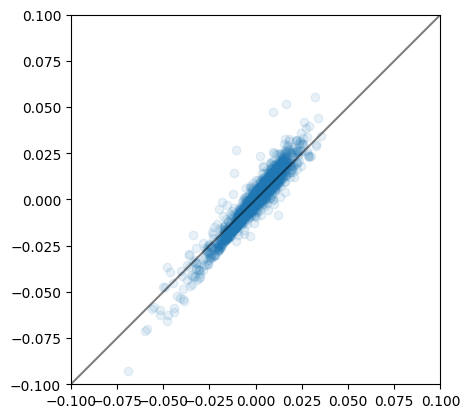

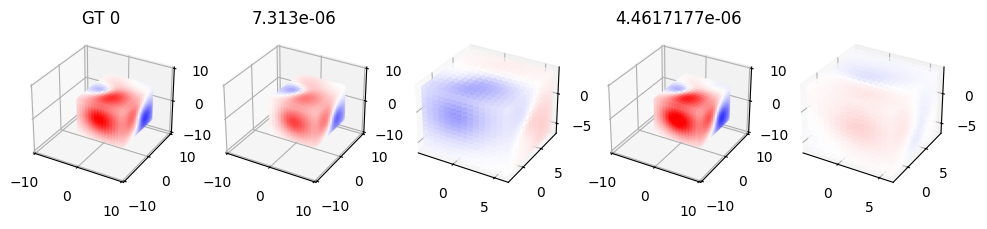

In [384]:
errors_train = []
batch = valid_batches[batchID]


mono_dc1, dipo_dc1 = DCM1.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
)

errors = evaluate_dc(batch, dipo_dc1, mono_dc1, batch_size, plot=True)
errors_train.append(errors)

# DCM2

In [385]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 2
# Training hyperparameters.
learning_rate = 0.001
# batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
DCM2 = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

# params = pd.read_pickle("checkpoints/dcm2-10000.0/2-0.026213709264993668-esp_params.pkl")
params = pd.read_pickle(get_lowest_loss("checkpoints/dcm2-10000.0/"))
# params = pd.read_pickle("checkpoints/dcm2-10000.0/7-0.0513247549533844-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-10.0/99-0.00013578754442278296-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-1000.0/1-0.005339722149074078-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-1000.0/26-0.008979301899671555-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-100.0/25-0.0007704171002842486-esp_params.pkl")



DCM2

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
)

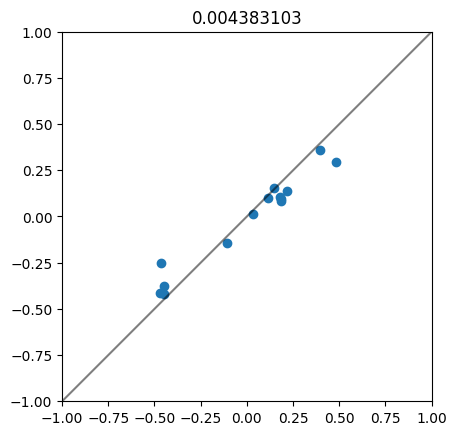

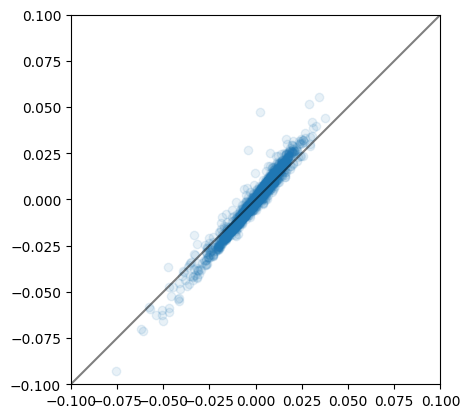

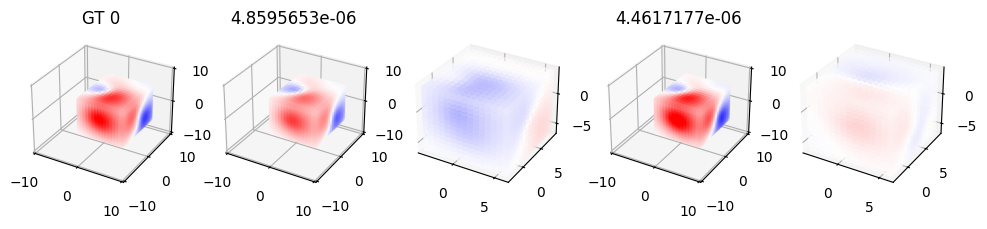

[[Array(4.8595653e-06, dtype=float32), Array(4.4617177e-06, dtype=float32)]]

In [386]:

    
mono_dc2, dipo_dc2 = DCM2.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
)

evaluate_dc(batch, dipo_dc2, mono_dc2, batch_size, plot=True)

#  DCM3

In [387]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 3
# Training hyperparameters.
learning_rate = 0.001
# batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
DCM3 = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle(get_lowest_loss("checkpoints/dcm3-10000.0/"))
# params = pd.read_pickle("checkpoints/dcm3-10000.0/3-0.01621761918067932-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-10.0/17-0.0001334990083705634-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-1000.0/26-0.0028469625394791365-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-100.0/14-0.0007971551967784762-esp_params.pkl")
DCM3

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
)

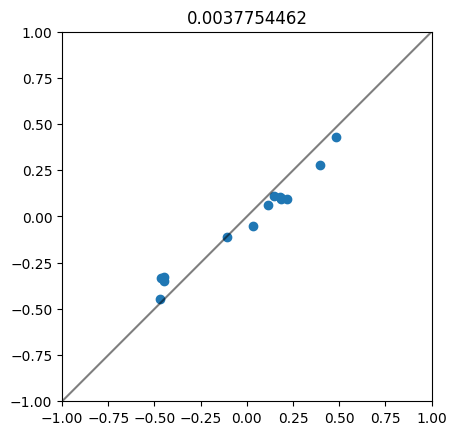

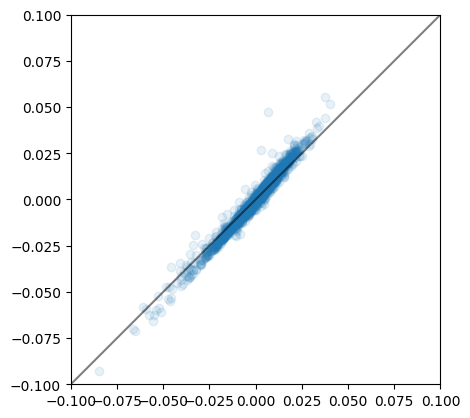

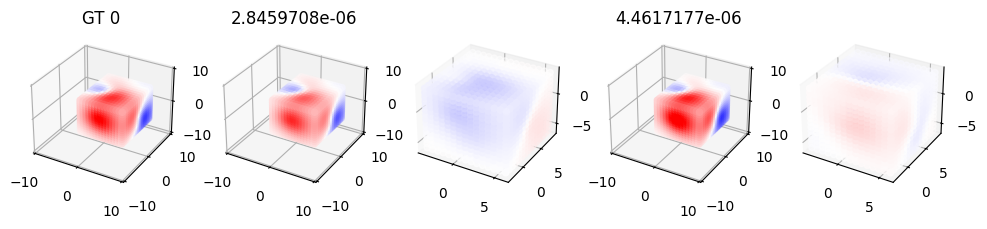

[[Array(2.8459708e-06, dtype=float32), Array(4.4617177e-06, dtype=float32)]]

In [388]:

    
mono_dc3, dipo_dc3 = DCM3.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
)

evaluate_dc(batch, dipo_dc3, mono_dc3, batch_size, plot=True)

#  DCM4

In [389]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 4
# Training hyperparameters.
learning_rate = 0.001
# batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
DCM4 = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm4-10000.0/1-0.01563119888305664-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-10.0/25-0.00011416388588258997-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-100.0/14-0.0007527425768785179-esp_params.pkl")
# 

DCM4

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
)

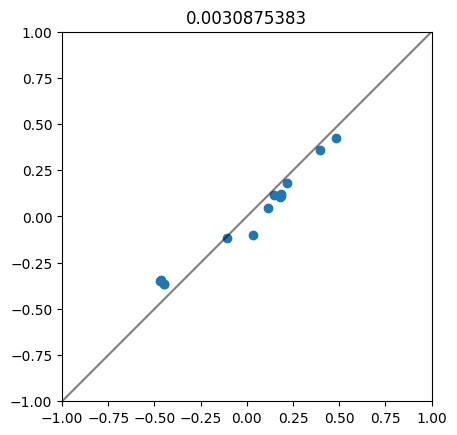

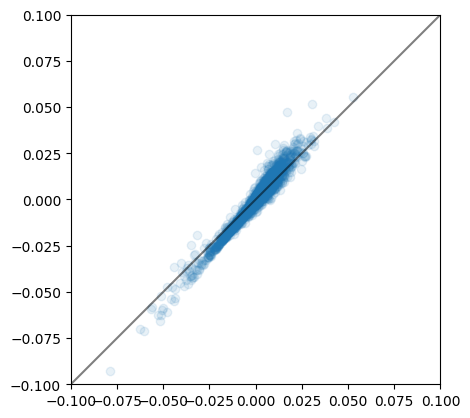

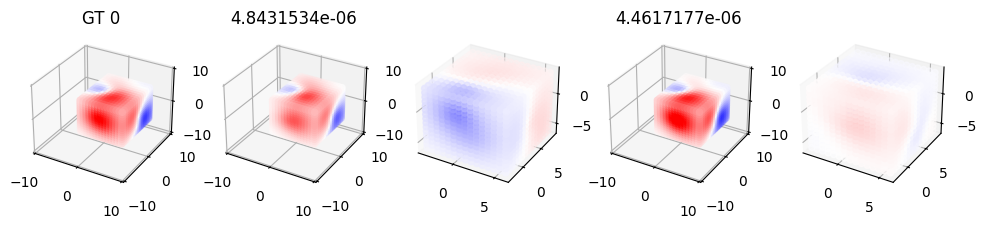

[[Array(4.8431534e-06, dtype=float32), Array(4.4617177e-06, dtype=float32)]]

In [390]:

    
mono_dc4, dipo_dc4 = DCM4.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
)

evaluate_dc(batch, dipo_dc4, mono_dc4, batch_size, plot=True)

In [391]:
dipo_dc4.shape, mono_dc4.shape

((60, 3, 4), (60, 4))

In [392]:
batch['atomic_numbers']

Array([8, 6, 6, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [393]:
def make_charge_xyz(mono, dipo, batch):
    n_dcm = mono.shape[1]
    i = 0
    a1_ = mono.reshape(batch_size, 60, n_dcm)[i]
    b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
    c1_ = batch["mono"].reshape(batch_size, 60)[i]
    print(b1_)
    nonzero = np.nonzero(c1_)
    dc = dipo.reshape(batch_size,60,3,n_dcm)
    dc = np.moveaxis(dc, -1, -2)
    dc = dc.reshape(batch_size, 60*n_dcm, 3)
    dcq = mono.reshape(batch_size,60*n_dcm,1)
    dcq = np.moveaxis(dcq, -1, -2)
    dcq = dcq.reshape(batch_size, 60*n_dcm, 1)
    idx_nozero = len(nonzero[0])*n_dcm

    n_atoms = idx_nozero // n_dcm

    atomwise_charge_array = np.zeros((n_atoms, n_dcm, 4))
    
    for count, (xyz, q) in enumerate(zip(dc[i][:idx_nozero], dcq[i][:idx_nozero])):
        print(count, count // n_dcm, xyz, q)
        atomwise_charge_array[count // n_dcm, count % n_dcm, :3] = xyz
        atomwise_charge_array[count // n_dcm, count % n_dcm, 3] = q[0]

    print(atomwise_charge_array.shape)

    return dc, dcq, atomwise_charge_array
    

In [394]:
def plot_3d_models(mono, dc, dcq, batch):
    n_dcm = mono.shape[1]
    i = 0
    xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
    elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
    
    from ase import Atoms
    from ase.visualize import view
    
    mol = Atoms(elem, xyz)
    V1 = view(mol, viewer="x3d")
    idx = len(nonzero[0])*n_dcm
    dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
    V2 = view(dcmol, viewer="x3d")
    combined = dcmol + mol
    V3 = view(combined, viewer="x3d")
    return V1, V2, V3

#  Structures

In [395]:
dc, dcq, atomwise_charge_array1 = make_charge_xyz(mono_dc1, dipo_dc1, batch)
V1, V2, V3 = plot_3d_models(mono_dc1, dc, dcq, batch)

[8 6 6 6 6 7 6 7 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 0 [-0.7095226  1.7544981  0.4792195] [-0.43748128]
1 1 [0.31060675 1.0406913  0.31293088] [0.23205318]
2 2 [ 1.2742786  1.3223622 -0.6631641] [-0.3104325]
3 3 [ 1.4482166  2.585802  -1.4442965] [0.17126909]
4 4 [ 2.1284485  3.0736837 -2.5177593] [-0.10380407]
5 5 [ 1.6989921  4.3224587 -2.851497 ] [-0.54516816]
6 6 [ 0.71493804  4.840285   -2.1017723 ] [0.16699825]
7 7 [ 0.51192194  3.6484954  -1.1530199 ] [-0.3423758]
8 8 [ 0.19092391 -0.00473835  0.49127018] [-0.06334991]
9 9 [2.297936   1.3339636  0.11844648] [-0.02838295]
10 10 [ 1.5703052  0.4676739 -1.2785585] [0.05230906]
11 11 [ 2.9706564  2.5218294 -3.0713708] [0.02248519]
12 12 [ 0.1718525  5.6561227 -2.0549169] [-0.02684063]
13 13 [-0.3777985  3.7149577 -0.3054939] [0.18931125]
(14, 1, 4)


In [396]:
# V1

In [397]:
# V2

In [398]:
# V3

In [399]:
dc, dcq, atomwise_charge_array2 = make_charge_xyz(mono_dc2, dipo_dc2, batch)
V1, V2, V3 = plot_3d_models(mono_dc2, dc, dcq, batch)

[8 6 6 6 6 7 6 7 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 0 [-0.7352086   1.9655392   0.52844715] [-0.32819235]
1 0 [-0.38141286  1.556015    0.36158663] [-0.08432247]
2 1 [0.24935992 1.0544299  0.17785048] [0.19785444]
3 1 [0.2770489  1.22243    0.22988294] [0.09670067]
4 2 [ 1.6676834  1.3884054 -0.7825433] [-0.19781324]
5 2 [ 1.2815448  1.215493  -0.6541283] [-0.05215745]
6 3 [ 1.4044541  2.4965096 -1.3762498] [-0.04798946]
7 3 [ 1.3459679  2.7143214 -1.4751774] [0.15106903]
8 4 [ 2.355808   2.8619933 -2.6176698] [-0.10914749]
9 4 [ 1.878182   3.1594367 -2.270046 ] [-0.03678265]
10 5 [ 1.7989658  4.3913403 -2.9843867] [-0.42229122]
11 5 [ 1.4335699  4.047806  -2.581323 ] [0.04623982]
12 6 [ 0.6206889  4.8402166 -2.0030673] [-0.05459156]
13 6 [ 0.8556907  4.4267726 -2.0126922] [0.1904361]
14 7 [ 0.45861617  3.6269941  -1.1037496 ] [-0.4551148]
15 7 [ 0.7112837  3.6012187 -1.4503307] [0.03417078]
16 8 [0.2839419  0.059

In [400]:
# V1

In [401]:
# V2

In [402]:
# V3

In [427]:
dc, dcq, atomwise_charge_array3 = make_charge_xyz(mono_dc3, dipo_dc3, batch)
V1, V2, V3 = plot_3d_models(mono_dc3, dc, dcq, batch)

[8 6 6 6 6 7 6 7 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 0 [-0.38141286  1.4576559   0.16861087] [0.01074195]
1 0 [-0.6851021   1.7919385   0.45118973] [-0.504593]
2 0 [-0.8039847  2.009204   0.3174953] [0.04860365]
3 1 [-0.05844693  0.72375315  0.32967013] [-0.0081479]
4 1 [0.23435742 0.9586363  0.1602169 ] [0.4255547]
5 1 [0.4322691  0.9122948  0.50719184] [0.01334961]
6 2 [ 1.1673093  1.6674347 -0.6732358] [0.0495779]
7 2 [ 1.4695559  1.3364116 -0.6662101] [-0.38161168]
8 2 [ 1.1344554  1.6674347 -0.669116 ] [-0.00264232]
9 3 [ 1.3307427  2.4564106 -1.2475027] [0.0671636]
10 3 [ 1.3775593  2.605587  -1.4139072] [0.05217862]
11 3 [ 1.3717481  2.3389716 -1.1758589] [-0.01664256]
12 4 [ 2.0895696  3.3520572 -2.649278 ] [0.0724566]
13 4 [ 2.1781669  3.0785677 -2.5678487] [-0.14910749]
14 4 [ 2.4149733  2.7840543 -2.8088915] [-0.03571624]
15 5 [ 1.4607453  4.047806  -2.581323 ] [0.0863892]
16 5 [ 1.7895894  4.407853  -2.

In [428]:
# V1

In [429]:
V2

In [430]:
V3

In [431]:
dc, dcq, atomwise_charge_array4 = make_charge_xyz(mono_dc4, dipo_dc4, batch)
V1, V2, V3 = plot_3d_models(mono_dc4, dc, dcq, batch)

[8 6 6 6 6 7 6 7 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 0 [-0.9281364   1.7863221   0.66046524] [-0.09278503]
1 0 [-0.38141286  1.6238532   0.16861087] [-0.11657111]
2 0 [-0.38141286  1.4576559   0.16861087] [0.03928477]
3 0 [-0.85988945  1.7792352   0.55856913] [-0.17910533]
4 1 [0.4182531  0.75004387 0.1945645 ] [0.09690145]
5 1 [0.5415531  0.85250974 0.4215407 ] [0.12967376]
6 1 [-0.05844693  0.72375315  0.50719184] [-0.01369429]
7 1 [0.31893903 0.72375315 0.27484387] [0.20923516]
8 2 [ 1.4982426   1.2968283  -0.64229584] [-0.22289196]
9 2 [ 1.4145998   1.3478826  -0.66671056] [-0.03888473]
10 2 [ 1.1344554   1.6674347  -0.59133226] [0.00591024]
11 2 [ 1.6763574  1.4711002 -0.7263116] [-0.08957246]
12 3 [ 1.3614397  2.6837676 -1.44111  ] [0.05178218]
13 3 [ 1.5936041  2.3389716 -1.501349 ] [-0.02858647]
14 3 [ 1.3232968  2.3389716 -1.2414298] [-0.01631278]
15 3 [ 1.3925519  2.3971753 -1.3412077] [0.09841761]
16 4 [

In [432]:
# V1

In [479]:
# V2

In [484]:
V3

In [ ]:
atomwise_charge_array1.shape

In [414]:
esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                         batch['vdw_surface'], batch['mono'], 
                         batch_size)

In [415]:
atomwise_charge_array2[:,:,:3] #.shape

array([[[-0.73520857,  1.96553922,  0.52844715],
        [-0.38141286,  1.55601501,  0.36158663]],

       [[ 0.24935992,  1.05442989,  0.17785048],
        [ 0.27704889,  1.22242999,  0.22988294]],

       [[ 1.66768336,  1.38840544, -0.7825433 ],
        [ 1.2815448 ,  1.21549296, -0.65412831]],

       [[ 1.40445411,  2.49650955, -1.37624979],
        [ 1.34596789,  2.71432137, -1.47517741]],

       [[ 2.35580802,  2.86199331, -2.61766982],
        [ 1.87818205,  3.1594367 , -2.270046  ]],

       [[ 1.79896581,  4.39134026, -2.98438668],
        [ 1.43356991,  4.04780579, -2.58132291]],

       [[ 0.62068892,  4.84021664, -2.00306726],
        [ 0.85569072,  4.42677259, -2.01269221]],

       [[ 0.45861617,  3.62699413, -1.10374963],
        [ 0.71128368,  3.6012187 , -1.45033073]],

       [[ 0.28394189,  0.05930871,  0.63659364],
        [ 0.31301108, -0.25548637,  0.81456149]],

       [[ 2.27448893,  1.34665167,  0.0387535 ],
        [ 2.34141684,  1.28295302,  0.18328682]],



In [416]:
def get_esp_rmse(atomwise_charge_array2):
    xyz2 = atomwise_charge_array2[:,:,:3].reshape(14*atomwise_charge_array2.shape[1], 3)
    q2 = atomwise_charge_array2[:,:,3].reshape(14*atomwise_charge_array2.shape[1])
    res2 = calc_esp(xyz2, q2,  batch['vdw_surface'][0], q2)
    esp_non_zero = np.nonzero(true)
    l2_loss = optax.l2_loss(res2[esp_non_zero], true[esp_non_zero])
    print(np.mean(l2_loss))

In [417]:
def get_esp_rmse_from_combined(combined):
    xyz2 = combined[:,:3]
    q2 = combined[:,3]
    res2 = calc_esp(xyz2, q2,  batch['vdw_surface'][0], q2)
    esp_non_zero = np.nonzero(true)
    l2_loss = optax.l2_loss(res2[esp_non_zero], true[esp_non_zero])
    print(np.mean(l2_loss))

In [465]:
def plot_3d_combined(combined, batch):
    xyz2 = combined[:,:3]
    q2 = combined[:,3]
    i = 0
    nonzero = np.nonzero(batch["atomic_numbers"].reshape(batch_size,60)[i])
    xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
    elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
    
    from ase import Atoms
    from ase.visualize import view
    
    mol = Atoms(elem, xyz)
    V1 = view(mol, viewer="x3d")
    dcmol = Atoms(["X" if _ > 0 else "He" for _ in q2], xyz2)
    V2 = view(dcmol, viewer="x3d")
    combined = dcmol + mol
    V3 = view(combined, viewer="x3d")
    return V1, V2, V3

In [466]:
def combine_chg_arrays(batch, atomwise_charge_array1, atomwise_charge_array2):
    i = 0
    nonzero = np.nonzero(batch["atomic_numbers"].reshape(batch_size,60)[i])
    xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
    elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
    
    chg_qs = []

    for i, element in enumerate(elem):
        print(i, element)
        if element == 1:
            chg_qs.append(atomwise_charge_array1[i])
        else:
            chg_qs.append(atomwise_charge_array2[i])
    result = np.concatenate(chg_qs)
    print(result.shape)
    return result

In [475]:
combined = combine_chg_arrays(batch, atomwise_charge_array1, atomwise_charge_array2)

0 8
1 6
2 6
3 6
4 6
5 7
6 6
7 7
8 1
9 1
10 1
11 1
12 1
13 1
(22, 4)


In [476]:
get_esp_rmse_from_combined(combined)

1.0299387e-05


In [478]:
V1, V2, V3 = plot_3d_combined(combined, batch)
V3

In [450]:
get_esp_rmse(atomwise_charge_array1)

7.313e-06


In [451]:
get_esp_rmse(atomwise_charge_array2)

4.8595666e-06


In [452]:
get_esp_rmse(atomwise_charge_array3)

2.8459763e-06


In [426]:
get_esp_rmse(atomwise_charge_array4)

4.8431525e-06
